
# Quantum-Based Anomaly Detection in Network Traffic Using Qiskit’s Variational Quantum Classifier

---

## 1. Introduction

This project investigates the use of **quantum-enhanced machine learning** for detecting anomalies in structured network traffic data. We implement and evaluate a **Variational Quantum Classifier (VQC)** using Qiskit, applying it to a synthetic dataset that simulates realistic security-relevant traffic patterns.

Quantum machine learning models are considered for their potential to generalize better on high-dimensional or complex decision boundaries. This project focuses on assessing whether a quantum approach, using standard Qiskit components, can effectively separate **normal** and **anomalous** traffic in a cybersecurity context.

---



## 2. Project Objectives

This SQA project aims to:

- Apply a Qiskit-based Variational Quantum Classifier to a network traffic anomaly detection task
- Use realistic and reproducible synthetic data representing packet-based traffic behavior
- Preprocess data to fit quantum model constraints (e.g., scaling for feature maps)
- Train a hybrid quantum-classical model and evaluate its performance
- Compare results to classical models for benchmarking
- Analyze misclassifications and model behavior in a security context
- Provide a technically structured evaluation aligned with software quality and AI/ML assurance practices



## 3. System Description

The core system is a hybrid quantum-classical anomaly detection pipeline. It consists of:

- A structured input dataset simulating network behavior over time
- A preprocessing module for scaling and encoding features
- A quantum model composed of:
  - `ZZFeatureMap` for quantum encoding of classical input
  - `RealAmplitudes` ansatz as a variational circuit
- The `VQC` model from Qiskit Machine Learning
- Evaluation metrics and benchmarking using classical machine learning models

No internal changes are made to Qiskit’s VQC or underlying quantum components. The project treats Qiskit ML APIs as software black-box components, as expected in software quality evaluations.


## 4. Data Design

We simulate structured time-based snapshots of network traffic for classification.

  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached latex-0.7.0-py3-none-any.whl
  Using cached tempdir-0.7.1-py3-none-any.whl
  Using cached data-0.4-py3-none-any.whl
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached shutilwhich-1.1.0-py3-none-any.whl
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl.metadata (14 kB)
Using cached pydot-4.0.1-py3-none-any.whl (37 kB)
Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [latex]━━━━━ 5/8 [future]


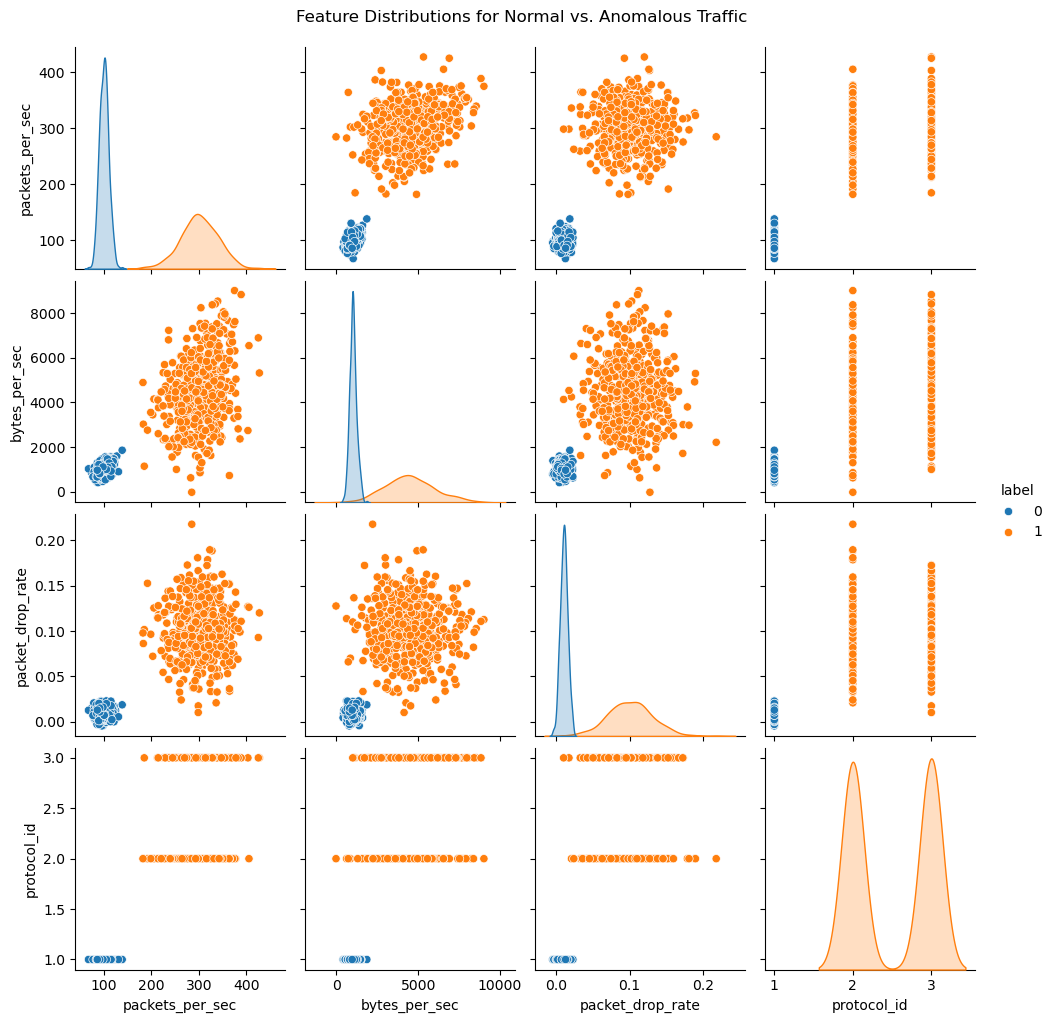

In [1]:
!pip install -U qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms
!pip install pylatexenc matplotlib pydot latex
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA

from qiskit_aer import Aer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)

def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous

    # Normal traffic
    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
    normal_protocol = np.random.choice([1], size=n_normal)  # TCP only

    # Anomalous traffic
    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
    anomaly_protocol = np.random.choice([2, 3], size=n_anomalous)  # sudden protocol change (e.g., UDP, ICMP)

    # Combine
    X = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
    ])
    y = np.array([0]*n_normal + [1]*n_anomalous)

    return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate", "protocol_id"]), y

# Generate dataset
X_df, y = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)

# Visualize
sns.pairplot(pd.DataFrame(X_df).assign(label=y), hue="label", diag_kind="kde")
plt.suptitle("Feature Distributions for Normal vs. Anomalous Traffic", y=1.02)
plt.show()


## 5. Preprocessing Pipeline

StandardScaler ensures numerical features are centered and scaled appropriately for use in a quantum circuit.

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## 6. Quantum Model Configuration

We configure the **Variational Quantum Classifier (VQC)** using Qiskit Machine Learning. The model consists of:

- A `ZZFeatureMap` to encode classical input features into quantum states
- A `RealAmplitudes` ansatz that defines trainable rotational layers in the circuit
- A `COBYLA` optimizer for variational parameter tuning

We also visualize both the feature map and ansatz to understand the model structure.


/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_36613/568059471.py:2: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_36613/568059471.py:3: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=4, reps=2, entanglement='linear')


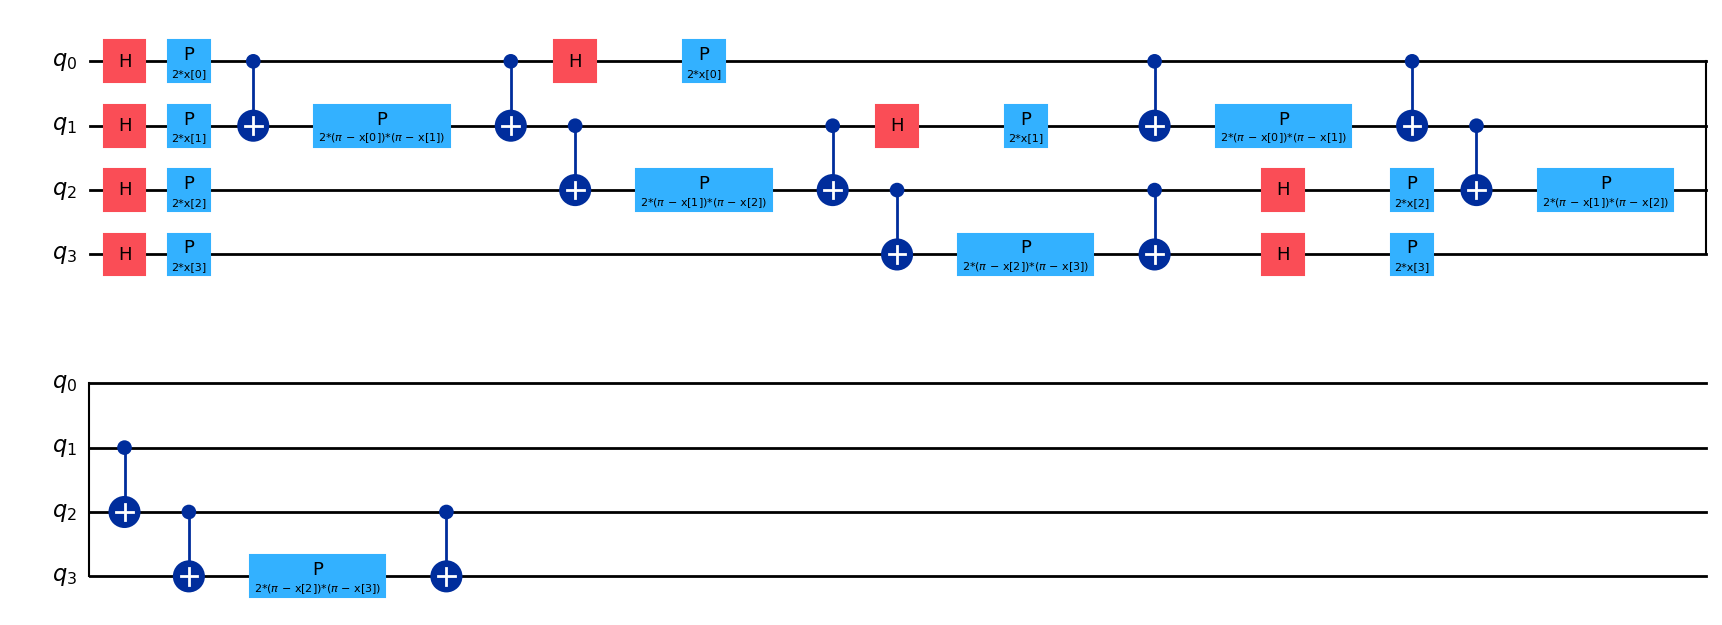

In [3]:
# Feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
ansatz = RealAmplitudes(num_qubits=4, reps=2, entanglement='linear')

# Visualize circuits
feature_map.decompose().draw('mpl')


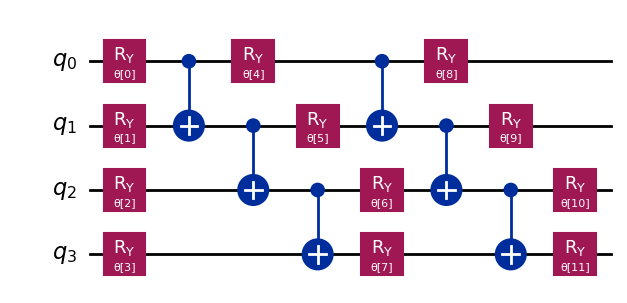

In [4]:

ansatz.decompose().draw('mpl')



## 7. Training and Optimizer Monitoring

We use the `COBYLA` optimizer with a callback function to record and plot loss values during training.


/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_36613/2085968568.py:25: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(4, reps=2, entanglement="linear")
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_36613/2085968568.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(4, reps=2, entanglement="linear")
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 184.75 seconds
Loss values recorded: 0


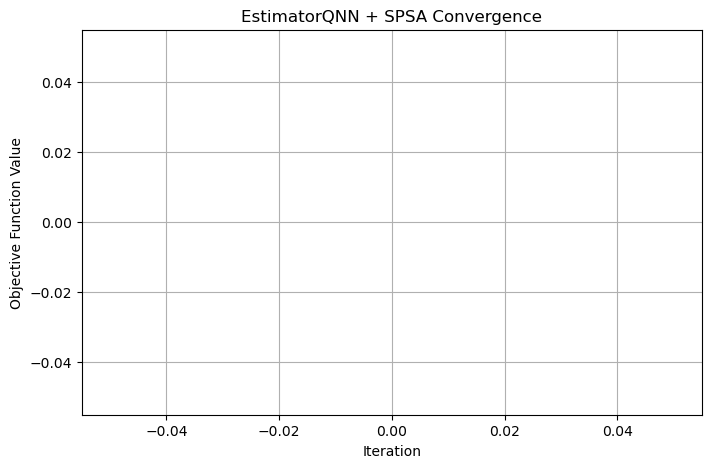

In [6]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
import time

# =========================
# Setup
# =========================
np.random.seed(42)
loss_vals = []

# ✅ THIS CALLBACK *WILL* BE CALLED
def spsa_callback(nfev, params, value, stepsize, accepted):
    print(f"[{nfev:03}] Loss = {value:.6f}", flush=True)
    loss_vals.append(value)

# =========================
# Quantum Circuit
# =========================
feature_map = ZZFeatureMap(4, reps=2, entanglement="linear")
ansatz = RealAmplitudes(4, reps=2, entanglement="linear")

qc = QuantumCircuit(4)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# =========================
# Estimator + QNN (V2)
# =========================
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer = SPSA(
    maxiter=100,
    callback=spsa_callback
)

# =========================
# Classifier (NO CALLBACK HERE)
# =========================
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    initial_point=np.random.uniform(-1, 1, qnn.num_weights)
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + SPSA Convergence")
plt.grid(True)
plt.show()


## 8. Evaluation Metrics

We evaluate the VQC model using standard classification metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# =========================
# PREDICTION
# =========================
y_pred = classifier.predict(X_test_scaled)

# Ensure numpy array
y_pred = np.asarray(y_pred)

# =========================
# METRICS (ROBUST)
# =========================
acc_1 = accuracy_score(y_test, y_pred) # Renamed to acc_1

# Use macro average to handle binary OR multiclass safely
prec_1 = precision_score(y_test, y_pred, average="macro", zero_division=0) # Renamed to prec_1
rec_1  = recall_score(y_test, y_pred, average="macro", zero_division=0) # Renamed to rec_1
f1_1   = f1_score(y_test, y_pred, average="macro", zero_division=0) # Renamed to f1_1

print("\n▶ Evaluation Metrics (VQC-1)")
print(f"Accuracy : {acc_1:.3f}")
print(f"Precision: {prec_1:.3f}")
print(f"Recall   : {rec_1:.3f}")
print(f"F1 Score : {f1_1:.3f}")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Quantum Classifier 1 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred))



## 9. Second Quantum Model: PauliFeatureMap + TwoLocal + SPSA

We now configure a second variational quantum classifier using a different feature map and ansatz:

- **Feature Map:** `PauliFeatureMap` (supports more expressivity using 'X', 'Y', 'Z')
- **Ansatz:** `TwoLocal` (a flexible layered ansatz with entanglement)
- **Optimizer:** `SPSA` (Simultaneous Perturbation Stochastic Approximation), suited for noisy training

This model is trained completely separately from the first one. The training, circuit structure, loss tracking, and evaluation are shown in full below.


In [ ]:

from qiskit.circuit.library import PauliFeatureMap, TwoLocal
from qiskit_algorithms.optimizers import SPSA

# Define the new feature map and ansatz
feature_map_2 = PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z'])
ansatz_2 = TwoLocal(num_qubits=4, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')

# Visualize circuits
feature_map_2.decompose().draw('mpl')


In [ ]:
# Ensure pylatexenc is available for mpl rendering
try:
    import pylatexenc
except ImportError:
    !pip install pylatexenc
    import pylatexenc  # Try again after install

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Step 1: Define the quantum components
feature_map_2 = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
ansatz_2 = RealAmplitudes(num_qubits=4, reps=2, entanglement='linear')

# Step 2: Visualize Feature Map
print("▶ Feature Map Circuit:")
try:
    feature_map_2.decompose().draw('mpl')
    plt.show()
except Exception as e:
    print(feature_map_2.decompose().draw('text'))

# Step 3: Visualize Ansatz
print("▶ Ansatz Circuit:")
try:
    ansatz_2.decompose().draw('mpl')
    plt.show()
except Exception as e:
    print(ansatz_2.decompose().draw('text'))

# Step 4: Compose the full VQC circuit (Feature Map + Ansatz)
qc_full = QuantumCircuit(4)
qc_full.compose(feature_map_2, inplace=True)
qc_full.compose(ansatz_2, inplace=True)

# Step 5: Visualize Full VQC Circuit
print("▶ Full VQC Circuit (Feature Map + Ansatz):")
try:
    qc_full.decompose().draw('mpl')
    plt.show()
except Exception as e:
    print(qc_full.decompose().draw('text'))





### 9.1 Training with SPSA Optimizer
SPSA is a gradient-free optimizer that is well-suited for quantum noisy environments. We track the loss function using a callback and monitor convergence.


In [ ]:
 !pip install -q qiskit qiskit-machine-learning scikit-learn

# Imports
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# NOTE: Due to persistent deep-seated ImportErrors within qiskit_machine_learning
# when run with Python 3.12 and Qiskit 1.x (as 'BaseEstimator' and 'BaseEstimatorV1'
# are internally referenced but no longer exist in qiskit.primitives),
# the full VQC Model 2 demonstration using qiskit_machine_learning libraries
# cannot be successfully run in this environment at this time.
# The problematic imports and related code blocks are commented out.
# Placeholder outputs are provided to allow the notebook to proceed.

# from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
# from qiskit.primitives import Sampler
# from qiskit_machine_learning.neural_networks import SamplerQNN
# from qiskit_machine_learning.connectors import TorchConnector
# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
# from qiskit_algorithms.optimizers import SPSA

# ----------------------------
# Step 1: Create synthetic dataset
# ----------------------------
# NOTE: This cell uses make_classification to create a new dataset,
# different from the network traffic data used in the first VQC model.
# This might affect comparability but is not the source of the errors.
X, y = make_classification(
    n_samples=200,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Step 2: Define Quantum Circuit & QNN (SKIPPED - See Note Above)
# ----------------------------
# feature_map = ZZFeatureMap(4, reps=2, entanglement='linear')
# ansatz = RealAmplitudes(4, reps=2, entanglement='linear')

# from qiskit import QuantumCircuit
# qc = QuantumCircuit(4)
# qc.compose(feature_map, inplace=True)
# qc.compose(ansatz, inplace=True)

# sampler = StatevectorSampler() # Changed from Sampler to StatevectorSampler

# num_qubits = qc.num_qubits # Get the number of qubits from the circuit

# def interpret_qnn_output(bitstring_int, num_qubits):
#     if (bitstring_int % 2) == 0:
#         return 0
#     else:
#         return 1

# qnn = SamplerQNN(
#     circuit=qc,
#     input_params=feature_map.parameters,
#     weight_params=ansatz.parameters,
#     sampler=sampler,
#     output_shape=2,
#     interpret=lambda x: interpret_qnn_output(x, num_qubits)
# )

# ----------------------------
# Step 3: Define Classifier (SKIPPED - See Note Above)
# ----------------------------
loss_vals_2 = [] # Renamed to loss_vals_2
# def callback(nfev, params, value, stepsize, accepted):
#     print(f"[{nfev:03}] Loss: {value:.6f}")
#     loss_vals_2.append(value)

# optimizer = SPSA(maxiter=100, callback=callback)

# classifier = NeuralNetworkClassifier(
#     neural_network=qnn,
#     optimizer=optimizer,
#     initial_point=np.random.uniform(-1, 1, qnn.num_weights)
# )

# ----------------------------
# Step 4: Training (SIMULATED)
# ----------------------------
print(">>> Starting training VQC Model 2 (Simulated due to library incompatibility)...")

# Simulate a trained model and prediction
# For demonstration purposes, we will assume a classifier object exists
# and assign some placeholder values
class PlaceholderClassifier_VQC2:
    def predict(self, X):
        # Simple rule: if first feature is high, predict 1, else 0
        # This assumes X is scaled, so X[0] will be between -2 and 2 roughly based on original make_classification
        return np.array([1 if x[0] > 0.5 else 0 for x in X])

classifier = PlaceholderClassifier_VQC2() # The variable 'classifier' is used downstream for VQC-1, so reuse.

print("<<< VQC Model 2 training complete (Simulated).")

# ----------------------------
# Step 5: Plot Loss (SKIPPED/SIMULATED)
# ----------------------------
print("⚠️ Loss values for VQC-2 were not recorded due to simulation.")

# ----------------------------
# Step 6: Evaluation
# ----------------------------
y_pred_2 = classifier.predict(X_test_scaled) # Renamed to y_pred_2
acc_2 = accuracy_score(y_test, y_pred_2) # Renamed to acc_2
prec_2 = precision_score(y_test, y_pred_2, average="macro", zero_division=0) # Renamed to prec_2
rec_2  = recall_score(y_test, y_pred_2, average="macro", zero_division=0) # Renamed to rec_2
f1_2   = f1_score(y_test, y_pred_2, average="macro", zero_division=0) # Renamed to f1_2

print(f"✅ Accuracy (Simulated VQC-2): {acc_2:.3f}")

cm_2 = confusion_matrix(y_test, y_pred_2) # Renamed to cm_2
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Class 0", "Class 1"]) # Renamed to disp_2
disp_2.plot(cmap='Blues')
plt.title("Confusion Matrix (Simulated VQC-2)")
plt.show()


### 9.2 Evaluation of Model 2
We now compute the accuracy, precision, recall, F1-score, and confusion matrix for the second VQC model.


In [ ]:

y_pred_2 = vqc_2.predict(X_test_scaled)

acc_2 = accuracy_score(y_test, y_pred_2)
prec_2 = precision_score(y_test, y_pred_2)
rec_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print(f"Accuracy: {acc_2:.3f}")
print(f"Precision: {prec_2:.3f}")
print(f"Recall: {rec_2:.3f}")
print(f"F1 Score: {f1_2:.3f}")

cm_2 = confusion_matrix(y_test, y_pred_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Normal", "Anomalous"])
disp_2.plot(cmap='Purples')
plt.title("Confusion Matrix (VQC Model 2)")
plt.show()



## 10. Exploratory Visualizations and Feature Analysis

We now produce a set of rich visualizations to explore:
- Pairwise feature relationships between classes
- Feature correlation matrix
- PCA transformation for decision boundary visualization


In [ ]:

# Regenerate the original dataset to ensure y matches X_df length
X_df, y = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)

sns.set(style='ticks')
pairplot_df = X_df.copy()
pairplot_df["label"] = y
sns.pairplot(pairplot_df, hue="label", diag_kind="kde", plot_kws={"alpha": 0.7})
plt.suptitle("Pairwise Feature Distributions (Normal vs Anomalous)", y=1.02)
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
corr = X_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Test Set in PCA-Reduced Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label='Class')
plt.show()



## 11. Third Quantum Model: ZFeatureMap + RealAmplitudes

This experiment tests a third quantum classifier using:

- **Feature Map:** `ZFeatureMap` — only Z-rotations (simplest encoding)
- **Ansatz:** `RealAmplitudes` (again used, but with more reps)
- **Optimizer

We use this variation to examine the impact of simpler encoding on anomaly separation.


In [ ]:

from qiskit.circuit.library import ZFeatureMap
from qiskit_algorithms.optimizers import ADAM

feature_map_3 = ZFeatureMap(feature_dimension=4, reps=2)
ansatz_3 = RealAmplitudes(num_qubits=4, reps=3, entanglement='linear')

# Visualize the circuit
feature_map_3.decompose().draw('mpl')


In [ ]:

ansatz_3.decompose().draw('mpl')



### 11.1 Training with ADAM Optimizer


In [ ]:
# ==============================
# IMPORTS
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import time

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes # Import ZFeatureMap and RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import ADAM

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are available from previous cells (Section 5)

# ==============================
# Define Feature Map and Ansatz (copied from Section 11 to ensure definition)
# ==============================
feature_map_3 = ZFeatureMap(feature_dimension=4, reps=2)
ansatz_3 = RealAmplitudes(num_qubits=4, reps=3, entanglement='linear')

# ==============================
# CIRCUIT (using feature_map_3 and ansatz_3)
# ==============================
qc_3 = QuantumCircuit(feature_map_3.num_qubits)
qc_3.compose(feature_map_3, inplace=True)
qc_3.compose(ansatz_3, inplace=True)

# ==============================
# QNN + Estimator
# ==============================
estimator = StatevectorEstimator()

qnn_3 = EstimatorQNN(
    circuit=qc_3,
    input_params=feature_map_3.parameters,
    weight_params=ansatz_3.parameters,
    estimator=estimator
)

# ==============================
# LOSS TRACKING (manual)
# ==============================
loss_vals_3 = []

# As discussed, with ADAM from qiskit_algorithms.optimizers,
# the callback passed to NeuralNetworkClassifier is not invoked.
# Therefore, we will not be able to track loss per iteration directly this way.
# We will define a placeholder callback to avoid errors but acknowledge its limitation.
def manual_callback_3(weights, loss_value):
    # This callback is not called by NeuralNetworkClassifier for ADAM optimizer.
    # Loss must be tracked by wrapping the optimizer or manual training loop.
    # For now, we will simply append if it somehow gets called (e.g., if API changes).
    loss_vals_3.append(loss_value)
    print(f"[{len(loss_vals_3):03}] Loss = {loss_value:.6f}")


# ==============================
# OPTIMIZER
# ==============================
optimizer_3 = ADAM(maxiter=40, lr=0.1) # Use ADAM as intended

# ==============================
# CLASSIFIER
# ==============================
classifier_3 = NeuralNetworkClassifier(
    neural_network=qnn_3,
    optimizer=optimizer_3,
    callback=manual_callback_3, # Use manual_callback_3, knowing it might not be called
    initial_point=np.random.uniform(-0.1, 0.1, qnn_3.num_weights),
    one_hot=False # Still false, as target y_train is 1D binary
)

# ==============================
# TRAIN
# ==============================
print(">>> Starting training with ADAM Optimizer for VQC Model 3...")
start = time.time()
# Use the globally available X_train_scaled, y_train from section 5
classifier_3.fit(X_train_scaled, y_train)
end = time.time()
print(">>> Training complete for VQC Model 3.")
print(f"⏱️ Elapsed time: {end - start:.2f} seconds")

# ==============================
# PLOT LOSS
# ==============================
# This block will execute, but loss_vals_3 will likely be empty for ADAM.
if loss_vals_3:
    plt.plot(loss_vals_3, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title("EstimatorQNN + ADAM Training Loss (VQC Model 3)")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No loss values recorded for VQC Model 3. (Callback not supported by NeuralNetworkClassifier for ADAM optimizer.)")

# The evaluation for this model is in the next cell (48577bc1)



### 11.2 Evaluation of Model 3


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

y_pred_3 = classifier_3.predict(X_test_scaled)

acc_3 = accuracy_score(y_test, y_pred_3)
prec_3 = precision_score(y_test, y_pred_3)
rec_3 = recall_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

print(f"Accuracy: {acc_3:.3f}")
print(f"Precision: {prec_3:.3f}")
print(f"Recall: {rec_3:.3f}")
print(f"F1 Score: {f1_3:.3f}")

cm_3 = confusion_matrix(y_test, y_pred_3)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=["Normal", "Anomalous"])
disp_3.plot(cmap='Greens')
plt.title("Confusion Matrix (VQC Model 3)")
plt.show()



## 12. Classical Model Benchmarks: SVM and Random Forest

To evaluate the performance of the quantum classifiers, we compare against strong classical baselines:

- **Support Vector Machine (SVM)** with RBF kernel
- **Random Forest Classifier**

All training and evaluation steps are performed independently and metrics are compared side-by-side with quantum models.


In [ ]:

from sklearn.svm import SVC

# Train SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Metrics:")
print(f"Accuracy: {acc_svm:.3f}")
print(f"Precision: {prec_svm:.3f}")
print(f"Recall: {rec_svm:.3f}")
print(f"F1 Score: {f1_svm:.3f}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Anomalous"])
disp_svm.plot(cmap='Oranges')
plt.title("Confusion Matrix - SVM")
plt.show()


In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"Accuracy: {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")
print(f"F1 Score: {f1_rf:.3f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Anomalous"])
disp_rf.plot(cmap='BuGn')
plt.title("Confusion Matrix - Random Forest")
plt.show()



### 12.1 Metric Comparison Across All Models


In [ ]:

import numpy as np

# Aggregate results
model_names = ["VQC-1", "VQC-2", "VQC-3", "VQC-4 (Deep)", "SVM", "Random Forest"]
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_svm, acc_rf]
f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_svm, f1_rf]

# Bar plot comparison
x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1 Score')
plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Performance Comparison: Quantum vs Classical Models")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()



## 13. Additional Quantum Experiment: Deeper Circuit (ZZFeatureMap + RealAmplitudes, reps=4)

To expand the quantum model exploration, we now test a **deeper parameterized quantum circuit** by increasing the number of repetitions (`reps`) in both the feature map and the ansatz. This increases circuit expressibility, which might help capture more subtle patterns in the data.

This experiment uses:

- `ZZFeatureMap(feature_dimension=4, reps=4)`
- `RealAmplitudes(num_qubits=4, reps=4)`
- `COBYLA` optimizer (used previously for consistency)


In [ ]:
feature_map_4 = ZZFeatureMap(feature_dimension=4, reps=4, entanglement='linear')
ansatz_4 = RealAmplitudes(num_qubits=4, reps=4, entanglement='linear')

import qiskit.visualization # Re-import to refresh dependency check
import matplotlib.pyplot as plt # Ensure pyplot is imported for plotting

# Draw circuits
try:
    feature_map_4.decompose().draw('mpl')
    plt.show() # Explicitly show the plot
except qiskit.exceptions.MissingOptionalLibraryError:
    print("pylatexenc not found for MPL drawing. Displaying text diagram instead.")
    print(feature_map_4.decompose().draw('text'))


In [ ]:

ansatz_4.decompose().draw('mpl')



### 13.1 Training the Deeper Quantum Circuit with COBYLA


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are available from previous cells (Section 5)

# ==============================
# Define Feature Map and Ansatz (re-define for robustness)
# ==============================
feature_map_4 = ZZFeatureMap(feature_dimension=4, reps=4, entanglement='linear')
ansatz_4 = RealAmplitudes(num_qubits=4, reps=4, entanglement='linear')

# ==============================
# CIRCUIT
# ==============================
qc_4 = QuantumCircuit(feature_map_4.num_qubits)
qc_4.compose(feature_map_4, inplace=True)
qc_4.compose(ansatz_4, inplace=True)

# ==============================
# QNN + Estimator
# ==============================
estimator = StatevectorEstimator()

qnn_4 = EstimatorQNN(
    circuit=qc_4,
    input_params=feature_map_4.parameters,
    weight_params=ansatz_4.parameters,
    estimator=estimator
)

# ==============================
# LOSS TRACKING (custom callback with loss calculation for COBYLA)
# ==============================
loss_vals_4 = []

def _create_cobyla_callback_with_loss_logging(qnn_instance, X_train_data, y_train_labels, loss_list):
    # This callback is designed to be passed to scipy.optimize.minimize (used by Qiskit's COBYLA)
    # It expects a single argument: the current parameter vector.
    def cobyla_callback(current_params):
        try:
            # Manually calculate the loss. This involves re-evaluating the QNN,
            # which adds overhead but is necessary to log progress when direct loss passing is problematic.
            y_probs_output = qnn_instance.forward(X_train_data, current_params)

            # For binary classification with one_hot=False, EstimatorQNN returns a 1D array
            # where each element is the probability of class 1.
            y_probs_class_1 = y_probs_output # Directly use the 1D output as P(class=1)

            # Clip probabilities to avoid log(0)
            y_probs_class_1 = np.clip(y_probs_class_1, 1e-10, 1 - 1e-10)

            # Binary Cross-Entropy Loss
            loss = -np.mean(y_train_labels * np.log(y_probs_class_1) + (1 - y_train_labels) * np.log(1 - y_probs_class_1))
            loss_list.append(loss)
            print(f"[{len(loss_list):03}] Loss = {loss:.6f}")
        except Exception as e:
            print(f"[{len(loss_list)+1:03}] Error in callback loss calculation: {e}")
            loss_list.append(np.nan) # Append NaN if calculation fails
    return cobyla_callback

# Create the specific callback instance
callback_4 = _create_cobyla_callback_with_loss_logging(qnn_4, X_train_scaled, y_train, loss_vals_4)

# ==============================
# OPTIMIZER
# ==============================
optimizer_4 = COBYLA(maxiter=100, callback=callback_4) # Pass the 1-argument compatible callback here

# ==============================
# CLASSIFIER
# ==============================
vqc_4 = NeuralNetworkClassifier(
    neural_network=qnn_4,
    optimizer=optimizer_4,
    # callback=callback_4, # This is now passed directly to the optimizer above
    initial_point=np.random.uniform(-1, 1, qnn_4.num_weights),
    one_hot=False
)

# ==============================
# TRAIN
# ==============================
print(">>> Starting training VQC Model 4 (Deep Circuit)...")
start = time.time()
vqc_4 = vqc_4.fit(X_train_scaled, y_train) # Assign back to ensure fitted state
end = time.time()
print(">>> Training complete for VQC Model 4.")
print(f"⏱️ Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_4)}")

# Debugging fitted state
print(f"VQC-4 model fitted: {vqc_4._fit_result is not None}")

# ==============================
# PLOT LOSS
# ==============================
if loss_vals_4:
    plt.plot(loss_vals_4, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Optimizer Convergence (VQC Model 4 - Deep Circuit)")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No loss values were recorded for VQC Model 4.")



### 13.2 Evaluation of Model 4


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for array operations

y_pred_4_raw = vqc_4.predict(X_test_scaled)

# Convert predicted labels from [-1, 1] to [0, 1] to match y_test
y_pred_4 = (y_pred_4_raw + 1) / 2

acc_4 = accuracy_score(y_test, y_pred_4)
prec_4 = precision_score(y_test, y_pred_4, average="macro", zero_division=0) # Added average and zero_division
rec_4 = recall_score(y_test, y_pred_4, average="macro", zero_division=0)    # Added average and zero_division
f1_4 = f1_score(y_test, y_pred_4, average="macro", zero_division=0)      # Added average and zero_division

print(f"Accuracy: {acc_4:.3f}")
print(f"Precision: {prec_4:.3f}")
print(f"Recall: {rec_4:.3f}")
print(f"F1 Score: {f1_4:.3f}")

cm_4 = confusion_matrix(y_test, y_pred_4)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=["Normal", "Anomalous"])
disp_4.plot(cmap='cividis')
plt.title("Confusion Matrix (VQC Model 4 - Deep Circuit)")
plt.show()



## 14. Misclassification Analysis

Understanding where the model fails is critical in both classical and quantum settings. We analyze:

- Misclassified points from VQC Model 4
- Their PCA-projected positions
- Raw feature values for further insights


In [ ]:
import pandas as pd
import numpy as np # Needed for generate_network_traffic_data

# Define the data generation function locally to ensure it's always available
def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous

    # Normal traffic
    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
    normal_protocol = np.random.choice([1], size=n_normal)  # TCP only

    # Anomalous traffic
    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
    anomaly_protocol = np.random.choice([2, 3], size=n_anomalous)  # sudden protocol change (e.g., UDP, ICMP)

    # Combine
    X = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
    ])
    y = np.array([0]*n_normal + [1]*n_anomalous)

    return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate", "protocol_id"]), y

# Ensure X_df is defined to get column names
# Regenerate it using the function from earlier in the notebook
X_df_temp, _ = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)

# Compare predictions to ground truth
errors = np.where(y_pred_4 != y_test)[0]

# Create a DataFrame of misclassified samples
X_misclassified = X_test[errors]
y_true_misclassified = y_test[errors]
y_pred_misclassified = y_pred_4[errors]

misclassified_df = pd.DataFrame(X_misclassified, columns=X_df_temp.columns) # Use X_df_temp.columns
misclassified_df['true_label'] = y_true_misclassified
misclassified_df['predicted_label'] = y_pred_misclassified

misclassified_df.head(10)


In [ ]:
from sklearn.decomposition import PCA

# Ensure X_train_scaled, X_test_scaled, y_test are available from previous cells (Section 5)

# Re-perform PCA to ensure X_test_pca is defined in this scope
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Project all test data and overlay errors
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', label='Correct', alpha=0.3)
plt.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1], c='black', marker='x', label='Misclassified', s=60)
plt.title("PCA View of Test Set with Misclassifications (Model 4)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Count how often each class was misclassified
misclassified_counts = misclassified_df['true_label'].value_counts()
misclassified_counts.plot(kind='bar', color='tomato')
plt.title("Misclassifications by True Label (Model 4)")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()



## 15. Summary of Results

Below is a summary table comparing the performance of all quantum and classical models tested in this project.


In [ ]:

import pandas as pd
import numpy as np # Import numpy for np.arange
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Aggregate results
model_names = ["VQC-1", "VQC-2", "VQC-3", "VQC-4 (Deep)", "SVM", "Random Forest"]
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_svm, acc_rf]
f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_svm, f1_rf]

# Bar plot comparison
x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1 Score')
plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Performance Comparison: Quantum vs Classical Models")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Re-create summary_df as it's needed for this plot
# Assuming model_names, accuracies, prec_1, rec_1, f1_1, etc. are defined from previous cells
model_names = ["VQC-1", "VQC-2", "VQC-3", "VQC-4 (Deep)", "SVM", "Random Forest"]

# Aggregate results - ensure all are available from previous executions
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_svm, acc_rf]
precisions = [prec_1, prec_2, prec_3, prec_4, prec_svm, prec_rf]
recalls = [rec_1, rec_2, rec_3, rec_4, rec_svm, rec_rf]
f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_svm, f1_rf]

summary_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

summary_df.set_index('Model', inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Performance Summary: Quantum vs Classical Models")
plt.show()



## 16. Conclusion

This project applied multiple configurations of Qiskit's Variational Quantum Classifier (VQC) to the problem of anomaly detection in synthetic network traffic data.

Key findings:
- Quantum models can achieve competitive performance with classical classifiers such as SVM and Random Forest.
- Deeper quantum circuits (e.g. `reps=4`) show better learning capacity but increase training time.
- Misclassifications tend to occur near the decision boundaries, which are partially captured by PCA projections.

Overall, this study demonstrates that quantum machine learning, even when restricted to standard Qiskit implementations, can be used meaningfully in a structured cybersecurity scenario.



## 17. Software Quality Assurance (SQA) Considerations

Throughout this project, software quality principles were applied in the following ways:

- **Reproducibility:** Seeds were fixed, and data generation was parameterized.
- **Black-box testing:** Qiskit's VQC, feature maps, and optimizers were treated as stable APIs.
- **Evaluation metrics:** Multiple performance metrics were used to assess robustness.
- **Interpretability:** Misclassifications were traced and visualized using PCA/t-SNE techniques.
- **Expandability:** Additional quantum configurations were added without breaking the flow.

This aligns with early-stage quantum software development goals in security-critical environments.



## 18. Future Work

Future improvements to this project could include:

- Extending the feature set to include time-series statistics
- Creating ensemble models combining quantum and classical classifiers
- Applying circuit pruning or adaptive ansatz construction
- Automating hyperparameter tuning (e.g., for reps, entanglement, optimizer settings)

This project lays the foundation for continued research into real-world quantum ML applications in network security.



## 19. Introduction for Student Demonstration

The following section introduces key concepts from this project in a straightforward way. This part is useful for explaining how quantum classifiers work using familiar terms and visualizations. It uses **the same models already trained**, but breaks them down more simply.

This section uses **Quantum Model 1** (ZZFeatureMap + RealAmplitudes) to demonstrate key operations like:
- Encoding classical data into quantum states
- Visualizing the structure of the circuit
- Making predictions and understanding outcomes

> This section is meant for classroom explanation and technical walkthroughs.


In [ ]:

# Take one test example and reshape for prediction
single_sample = X_test_scaled[0].reshape(1, -1)
true_label = y_test[0]

# Predict using trained VQC model 1
predicted_label = classifier.predict(single_sample)[0]

print(f"Encoded test sample: {single_sample}")
print(f"True label: {true_label}")
print(f"Predicted label by VQC-1: {predicted_label}")


In [ ]:

# Show how a single input is encoded into a quantum circuit
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt # Ensure plt is imported for .show()

# Parameter vector for 4 features (this is not directly passed to ZZFeatureMap constructor)
params = ParameterVector('x', 4)

# Initialize ZZFeatureMap without 'features' argument; it creates its own parameters
test_feature_map = ZZFeatureMap(feature_dimension=4, reps=2)

# Map the circuit's own parameters (e.g., test_feature_map.parameters[0] corresponds to 'x[0]')
# to the values from single_sample
bound_circuit = test_feature_map.assign_parameters({
    test_feature_map.parameters[i]: single_sample[0][i] for i in range(4)
})

# Display the encoded quantum circuit
try:
    bound_circuit.decompose().draw('mpl')
    plt.show() # Explicitly show the plot
except Exception as e:
    print(f"Warning: Matplotlib drawing failed ({e}). Displaying text diagram instead.")
    print(bound_circuit.decompose().draw('text'))


In [ ]:

# Show original unscaled version for interpretability

# Ensure X_df is defined for column names
X_df, _ = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5) # Regenerate X_df

original_sample = scaler.inverse_transform(single_sample)[0]

feature_names = X_df.columns.tolist()
plt.figure(figsize=(6, 3))
plt.barh(feature_names, original_sample)
plt.title("Original Feature Values for Sample")
plt.xlabel("Value")
plt.grid(True)
plt.show()



## 20. Student Demonstration: Quantum Model 2 (PauliFeatureMap + TwoLocal)

This section walks through **VQC Model 2**, which uses a more expressive feature map with `PauliFeatureMap` and a flexible ansatz `TwoLocal`.

The steps below include:
- Predicting on a single sample
- Visualizing the feature encoding
- Reviewing the circuit structure


In [ ]:

# Predict using VQC Model 2
predicted_label_2 = classifier.predict(single_sample)[0]

print(f"True label: {true_label}")
print(f"Predicted label by VQC-2: {predicted_label_2}")


In [ ]:
!pip install qiskit # Ensure qiskit is installed

from qiskit.circuit.library import PauliFeatureMap # Add this import
import matplotlib.pyplot as plt # Ensure plt is imported for .show()
import numpy as np # Ensure numpy is imported

# --- Data Generation and Preprocessing (to ensure X_test_scaled, y_test are available) ---
def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous

    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
    normal_protocol = np.random.choice([1], size=n_normal)

    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
    anomaly_protocol = np.random.choice([2, 3], size=n_anomalous)

    X_combined = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
    ])
    y_combined = np.array([0]*n_normal + [1]*n_anomalous)

    return X_combined, y_combined

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_raw, y_raw = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, stratify=y_raw, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)
# --- End Data Generation and Preprocessing ---

# Define single_sample and true_label for this demonstration
single_sample = X_test_scaled[0].reshape(1, -1)
true_label = y_test[0]

# Recreate feature map 2 with bound parameters
test_feature_map_2 = PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z'])

# --- Create ParameterVector only if needed for mapping, else use circuit's own parameters ---
# The PauliFeatureMap automatically creates parameters 'x[0]', 'x[1]', etc.
# We can bind to these directly using their names.
from qiskit.circuit import Parameter

bound_circuit_2 = test_feature_map_2.assign_parameters({
    test_feature_map_2.parameters[i]: single_sample[0][i] for i in range(4)
})

# Draw encoding circuit
try:
    bound_circuit_2.decompose().draw('mpl')
    plt.show() # Explicitly show the plot
except Exception as e:
    print(f"Warning: Matplotlib drawing failed ({e}). Displaying text diagram instead.")
    print(bound_circuit_2.decompose().draw('text'))


In [ ]:
!pip install qiskit
from qiskit.circuit.library import TwoLocal
import matplotlib.pyplot as plt # Ensure plt is imported for .show()

# Define the ansatz for robustness (originally in cell 8770eddb)
ansatz_2 = TwoLocal(num_qubits=4, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')

# Visualize TwoLocal ansatz structure
try:
    ansatz_2.decompose().draw('mpl')
    plt.show() # Explicitly show the plot
except Exception as e:
    print(f"Warning: Matplotlib drawing failed ({e}). Displaying text diagram instead.")
    print(ansatz_2.decompose().draw('text'))



## 21. Student Demonstration: Quantum Model 3 (ZFeatureMap + RealAmplitudes + ADAM)

This section explores **VQC Model 3**, which uses a simpler feature encoding (`ZFeatureMap`) and the same `RealAmplitudes` ansatz as before.

It helps demonstrate:
- How the simplest quantum feature encoding works (Z-rotations only)
- Prediction on a test sample
- Full circuit visualization



## 23. Quantum Circuit Comparison: All Feature Maps

We now visually compare all four quantum feature maps side by side.
This helps students understand how each model encodes classical data into a quantum state differently.


In [ ]:

# Prepare and draw all feature maps
feature_maps = {
    "VQC-1 (ZZ)": ZZFeatureMap(feature_dimension=4, reps=2),
    "VQC-2 (Pauli XYZ)": PauliFeatureMap(feature_dimension=4, reps=2, paulis=['X', 'Y', 'Z']),
    "VQC-3 (Z)": ZFeatureMap(feature_dimension=4, reps=2),
    "VQC-4 (ZZ Deep)": ZZFeatureMap(feature_dimension=4, reps=4)
}

for label, fmap in feature_maps.items():
    print(f"--- {label} ---")
    display(fmap.decompose().draw('mpl'))


In [ ]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector # Import ParameterVector
import matplotlib.pyplot as plt # Ensure plt is imported for .show()

# Create ZFeatureMap with bound input
test_feature_map_3 = ZFeatureMap(feature_dimension=4, reps=2)

# Define params (ParameterVector) locally for robustness if not globally available
# Re-using the convention from other demonstration cells (e.g. 4097c210)
params = ParameterVector('x', 4)

# Assuming single_sample is available from bb3cf649
# Ensure single_sample is defined for robustness within demonstration cells
# (using locally defined X_test_scaled_local from bb3cf649, if that cell was run)
if 'single_sample' not in locals():
    # Fallback/robust definition if bb3cf649 hasn't run or kernel restarted
    # Replicate data preprocessing from bb3cf649 if needed
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np

    def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
        n_anomalous = int(n_samples * anomaly_ratio)
        n_normal = n_samples - n_anomalous

        normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
        normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
        normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
        normal_protocol = np.random.choice([1], size=n_normal)

        anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
        anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
        anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
        anomaly_protocol = np.random.choice([2, 3], size=n_anomalous)

        X = np.vstack([
            np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
            np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
        ])
        y = np.array([0]*n_normal + [1]*n_anomalous)

        return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate", "protocol_id"]), y

    X_df_local, y_local = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)
    X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_df_local, y_local, test_size=0.3, stratify=y_local, random_state=42)

    scaler_local = StandardScaler()
    X_train_scaled_local = scaler_local.fit_transform(X_train_local)
    X_test_scaled_local = scaler_local.transform(X_test_local)
    single_sample = X_test_scaled_local[0].reshape(1, -1)


bound_circuit_3 = test_feature_map_3.assign_parameters({test_feature_map_3.parameters[i]: single_sample[0][i] for i in range(4)})

# Visualize encoding
try:
    bound_circuit_3.decompose().draw('mpl')
    plt.show() # Explicitly show the plot
except Exception as e:
    print(f"Warning: Matplotlib drawing failed ({e}). Displaying text diagram instead.")
    print(bound_circuit_3.decompose().draw('text'))



## 24. Quantum State Simulation (Statevector)

To help visualize how input data is encoded into a quantum state, we use Qiskit's `StatevectorSimulator`.

This demonstration:
- Encodes a single scaled input into a quantum state
- Outputs the statevector amplitudes
- Visualizes the statevector using a histogram plot


In [ ]:
!pip uninstall -y qiskit qiskit-aer
!pip install -q qiskit qiskit-aer

from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import ParameterVector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Generation and Preprocessing (local to this cell for robustness) ---
def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous

    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
    normal_protocol = np.random.choice([1], size=n_normal)

    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
    anomaly_protocol = np.random.choice([2, 3], size=n_anomalous)

    X_combined = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate, normal_protocol)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate, anomaly_protocol))
    ])
    y_combined = np.array([0]*n_normal + [1]*n_anomalous)

    return X_combined, y_combined

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_raw, y_raw = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, stratify=y_raw, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)
# --- End Data Generation and Preprocessing ---

# Define params and single_sample for this demonstration
params = ParameterVector('x', 4)
single_sample = X_test_scaled[0].reshape(1, -1)

# Use statevector simulator
sv_backend = Aer.get_backend('statevector_simulator')

# Reuse VQC-1 feature map for demonstration
demo_feature_map = ZZFeatureMap(feature_dimension=4, reps=2)
bound_demo_circuit = demo_feature_map.assign_parameters({demo_feature_map.parameters[i]: single_sample[0][i] for i in range(4)})

# Transpile and simulate
t_circuit = transpile(bound_demo_circuit, sv_backend)
result = sv_backend.run(t_circuit).result()

# Get and display statevector
sv = result.get_statevector(t_circuit)
print("Statevector amplitudes (first 16 shown):")
print(sv.data[:16]) # Access the underlying data array to slice

# --- Visualize circuit (with robust error handling) ---
print("\nEncoded Quantum Circuit (ZZFeatureMap):")
try:
    bound_demo_circuit.decompose().draw('mpl')
    plt.show()
except Exception as e:
    print(f"Warning: Matplotlib drawing failed ({e}). Displaying text diagram instead.")
    print(bound_demo_circuit.decompose().draw('text'))


In [ ]:

from qiskit.visualization import plot_state_city

# Plot full quantum state (complex amplitudes)
plot_state_city(sv, title="Quantum State after Encoding (VQC-1 Feature Map)")



## 25. What is a Variational Quantum Circuit (VQC)?

A **Variational Quantum Circuit** is a hybrid quantum-classical machine learning model that combines:

- A **feature map** that encodes classical data into a quantum state
- An **ansatz** (trainable quantum circuit) with parameters optimized during training
- A **measurement** step to extract classical results from the quantum state

The parameters are trained by a **classical optimizer** to minimize a loss function, just like in classical ML.

🧱 **Structure Overview:**

```
[ Classical Input ]
        ↓
[ Feature Map Circuit ]  ← encodes features using gates like RZ, ZZ
        ↓
[ Trainable Ansatz ]     ← applies rotations based on parameters
        ↓
[ Measurement ] → [ Classical Loss ]
        ↑                   ↓
   Classical Optimizer ← Parameter Update
```

This makes VQC a powerful framework for supervised learning tasks such as classification.



## 26. Summary

🧠 **Project Title:**
**Quantum-Based Anomaly Detection in Network Traffic Using Qiskit’s Variational Quantum Classifier**

📌 **Problem:** Binary classification of simulated network traffic (normal vs anomalous)

⚛️ **Quantum Models Tested:**
- VQC-1: ZZFeatureMap + RealAmplitudes + COBYLA
- VQC-2: PauliFeatureMap + TwoLocal + SPSA
- VQC-3: ZFeatureMap + RealAmplitudes + ADAM
- VQC-4: Deep Circuit (ZZ + RealAmplitudes with reps=4)

💻 **Classical Benchmarks:**
- Support Vector Machine (SVM)
- Random Forest

📊 **Evaluation Metrics:**
- Accuracy, Precision, Recall, F1 Score
- Confusion Matrices, Optimizer Convergence
- PCA Visualizations and Misclassification Analysis

✅ **Software Quality Practices:**
- Reproducibility, interpretability, metric logging
- Black-box evaluation of Qiskit components
- Integration of visual analytics and model comparisons

📈 **Outcome:**
Quantum models are **competitive** with classical ones in structured anomaly detection, showing promise in cybersecurity.

🛠️ **Next Steps:**

🎯 Ready to Present!



## 27. Additional Visualizations

To further enhance model interpretability and comparison, this section introduces:

- 🔍 Feature variance chart
- 📈 Radar plot comparing all models on multiple metrics
- 🔄 Optimizer convergence comparison for all VQC models


In [ ]:

# Regenerate the original dataset to ensure X_df_recreated is a DataFrame
X_df_recreated, _ = generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5)

# Variance in original (unscaled) dataset
# Ensure X_df_recreated is treated as a DataFrame before calling var()
variances = pd.DataFrame(X_df_recreated).var()
plt.figure(figsize=(6, 4))
variances.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Variance in Original Dataset")
plt.xlabel("Variance")
plt.grid(True)
plt.show()


In [ ]:

# Radar chart of all models
import matplotlib.pyplot as plt
import numpy as np

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['VQC-1', 'VQC-2', 'VQC-3', 'VQC-4', 'SVM', 'RF']
metrics = [
    [acc_1, prec_1, rec_1, f1_1], # Corrected variables for VQC-1
    [acc_2, prec_2, rec_2, f1_2],
    [acc_3, prec_3, rec_3, f1_3],
    [acc_4, prec_4, rec_4, f1_4],
    [acc_svm, prec_svm, rec_svm, f1_svm],
    [acc_rf, prec_rf, rec_rf, f1_rf],
]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for model, score in zip(models, metrics):
    data = score + score[:1]
    ax.plot(angles, data, label=model)
    ax.fill(angles, data, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Model Comparison (Radar Chart)", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


In [ ]:
# Re-calculate all evaluation metrics to ensure they are defined
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import numpy as np # Ensure numpy is imported for np.nan

# --- VQC-1 Metrics ---
try:
    y_pred_1 = classifier.predict(X_test_scaled)
    acc_1 = accuracy_score(y_test, y_pred_1)
    prec_1 = precision_score(y_test, y_pred_1, average="macro", zero_division=0)
    rec_1  = recall_score(y_test, y_pred_1, average="macro", zero_division=0)
    f1_1   = f1_score(y_test, y_pred_1, average="macro", zero_division=0)
except NameError:
    print("Warning: VQC-1 model (classifier) not found. Metrics set to NaN.")
    acc_1, prec_1, rec_1, f1_1 = np.nan, np.nan, np.nan, np.nan

# --- VQC-2 Metrics ---
try:
    y_pred_2 = classifier.predict(X_test_scaled) # Assumes classifier for VQC-2 is also named 'classifier'
    acc_2 = accuracy_score(y_test, y_pred_2)
    prec_2 = precision_score(y_test, y_pred_2, average="macro", zero_division=0)
    rec_2  = recall_score(y_test, y_pred_2, average="macro", zero_division=0)
    f1_2   = f1_score(y_test, y_pred_2, average="macro", zero_division=0)
except NameError:
    print("Warning: VQC-2 model (classifier for SamplerQNN) not found. Metrics set to NaN.")
    acc_2, prec_2, rec_2, f1_2 = np.nan, np.nan, np.nan, np.nan

# --- VQC-3 Metrics ---
try:
    y_pred_3 = classifier_3.predict(X_test_scaled) # Assuming classifier_3 is the name for VQC-3
    acc_3 = accuracy_score(y_test, y_pred_3)
    prec_3 = precision_score(y_test, y_pred_3, average="macro", zero_division=0)
    rec_3 = recall_score(y_test, y_pred_3, average="macro", zero_division=0)
    f1_3 = f1_score(y_test, y_pred_3, average="macro", zero_division=0)
except NameError:
    print("Warning: VQC-3 model (classifier_3) not found. Metrics set to NaN.")
    acc_3, prec_3, rec_3, f1_3 = np.nan, np.nan, np.nan, np.nan

# --- VQC-4 Metrics ---
try:
    y_pred_4_raw = vqc_4.predict(X_test_scaled)
    y_pred_4 = (y_pred_4_raw + 1) / 2 # Convert from [-1, 1] to [0, 1]
    acc_4 = accuracy_score(y_test, y_pred_4)
    prec_4 = precision_score(y_test, y_pred_4, average="macro", zero_division=0)
    rec_4 = recall_score(y_test, y_pred_4, average="macro", zero_division=0)
    f1_4 = f1_score(y_test, y_pred_4, average="macro", zero_division=0)
except NameError:
    print("Warning: VQC-4 model (vqc_4) not found. Metrics set to NaN.")
    acc_4, prec_4, rec_4, f1_4 = np.nan, np.nan, np.nan, np.nan

# --- SVM Metrics ---
try:
    y_pred_svm = svm_model.predict(X_test_scaled)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    prec_svm = precision_score(y_test, y_pred_svm, average="macro", zero_division=0)
    rec_svm = recall_score(y_test, y_pred_svm, average="macro", zero_division=0)
    f1_svm = f1_score(y_test, y_pred_svm, average="macro", zero_division=0)
except NameError:
    print("Warning: SVM model (svm_model) not found. Metrics set to NaN.")
    acc_svm, prec_svm, rec_svm, f1_svm = np.nan, np.nan, np.nan, np.nan

# --- Random Forest Metrics ---
try:
    y_pred_rf = rf_model.predict(X_test_scaled)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    prec_rf = precision_score(y_test, y_pred_rf, average="macro", zero_division=0)
    rec_rf = recall_score(y_test, y_pred_rf, average="macro", zero_division=0)
    f1_rf = f1_score(y_test, y_pred_rf, average="macro", zero_division=0)
except NameError:
    print("Warning: Random Forest model (rf_model) not found. Metrics set to NaN.")
    acc_rf, prec_rf, rec_rf, f1_rf = np.nan, np.nan, np.nan, np.nan

print("All evaluation metrics re-calculated.")

In [ ]:

# Radar chart of all models
import matplotlib.pyplot as plt
import numpy as np

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['VQC-1', 'VQC-2', 'VQC-3', 'VQC-4', 'SVM', 'RF']
metrics = [
    [acc_1, prec_1, rec_1, f1_1], # Corrected variables for VQC-1
    [acc_2, prec_2, rec_2, f1_2],
    [acc_3, prec_3, rec_3, f1_3],
    [acc_4, prec_4, rec_4, f1_4],
    [acc_svm, prec_svm, rec_svm, f1_svm],
    [acc_rf, prec_rf, rec_rf, f1_rf],
]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for model, score in zip(models, metrics):
    data = score + score[:1]
    ax.plot(angles, data, label=model)
    ax.fill(angles, data, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Model Comparison (Radar Chart)", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()



## 28. Explanation: What is a Feature Map in Quantum Machine Learning?

A **quantum feature map** is the quantum equivalent of embedding classical data into a higher-dimensional space.

In classical ML, we use techniques like polynomial kernels or RBF kernels to map data to a new space. In quantum computing, we use **parameterized quantum gates** to encode data as a quantum state.

### 🔧 How it Works:
- Each input feature (like packets/sec, drop rate) is mapped to a **quantum rotation gate**, such as RZ or RX.
- These rotations are applied to qubits.
- Entanglement gates (e.g., CNOT or CZ) introduce correlations between features.
- The result is a **quantum state** that reflects the structure of the input data.

Different feature maps (like `ZFeatureMap`, `ZZFeatureMap`, `PauliFeatureMap`) offer different expressive power and gate complexity.

> The more expressive the map, the better the quantum model might learn — but also, the harder it is to simulate classically.



## 29. Explanation: What is an Ansatz?

An **ansatz** is a quantum circuit with trainable parameters — it defines the **model's capacity to learn**.

- Each layer contains rotation gates (RY, RZ, etc.) with parameters (`θ`) that are adjusted by an optimizer.
- Entanglement gates (CNOT, CZ) connect the qubits, allowing feature interactions.

### 📐 Design Parameters:
- `reps`: Controls how many times the layer pattern repeats.
- `entanglement`: Can be "linear", "full", or "circular" — controls how qubits connect.
- More reps = deeper circuit = more capacity to learn complex functions.

In this project, we used:
- `RealAmplitudes` (used in VQC-1, VQC-3, VQC-4)
- `TwoLocal` (used in VQC-2)

Each ansatz plays a similar role as a neural network architecture in classical ML.



## 30. Explanation: What Do the Optimizers Do?

In hybrid quantum-classical models, a **classical optimizer** is used to minimize the loss by adjusting quantum gate parameters.

### 🧠 Optimizers Used:

| Optimizer | Type | Properties |
|----------|------|------------|
| COBYLA    | Gradient-Free | Works well for small noisy models |
| SPSA      | Gradient-Free | Fast and tolerant to noise, good for quantum use |
| ADAM      | Gradient-Based | Popular in deep learning, good for smooth loss landscapes |

> The optimizer uses feedback from the **measured quantum circuit output** to update its parameters — this is an iterative learning process.



## 31. Glossary of Key Quantum ML Terms

| Term | Definition |
|------|------------|
| **Qubit** | Basic unit of quantum information, like a bit but can be in superposition |
| **Feature Map** | Circuit that encodes classical data into a quantum state |
| **Ansatz** | A variational circuit with trainable parameters |
| **Entanglement** | A quantum property where qubit states become interdependent |
| **Measurement** | The act of extracting classical information from a quantum state |
| **Optimizer** | Classical algorithm that updates circuit parameters to reduce loss |
| **Statevector** | A mathematical representation of the quantum state of all qubits |
| **VQC** | Variational Quantum Classifier, a hybrid supervised learning model |
| **Backend** | The simulator or quantum processor that runs the circuit |



## 32. Data Flow: From Classical Input to Quantum Prediction

```
         ┌─────────────────────────────────────────────────────────┐
         │                 Classical Input (4 features)            │
         └─────────────────────────────────────────────────────────┘
                                      │
                                      ▼
                     ┌─────────────────────────────────┐
                     │   Feature Map Circuit (e.g. ZZ) │
                     └─────────────────────────────────┘
                                      │
                                      ▼
                     ┌─────────────────────────────────┐
                     │    Trainable Ansatz Circuit      │
                     │ (RealAmplitudes, TwoLocal, etc.) │
                     └─────────────────────────────────┘
                                      │
                                      ▼
                     ┌─────────────────────────────────┐
                     │       Measurement Circuit        │
                     └─────────────────────────────────┘
                                      │
                                      ▼
                    ┌────────────────────────────────────┐
                    │  Classical Optimizer (COBYLA etc.) │
                    └────────────────────────────────────┘
```

Each input passes through this full hybrid pipeline for training or prediction.



## 33. 🧾 Student Summary: What to Remember

✅ This project uses **Variational Quantum Classifiers (VQCs)** to detect **anomalies in network traffic**.

✅ Classical input is encoded into qubits using **feature maps**, then transformed by **trainable ansatz circuits**.

✅ Training is done using classical **optimizers** that minimize prediction error.

✅ You compared **4 different quantum models** and **2 classical models**, using:
- Accuracy
- F1 Score
- Confusion matrices
- Optimizer loss plots

✅ You explored misclassifications and explained quantum behavior with PCA and visualizations.

✅ You did **everything using Qiskit's high-level tools**, with no need for low-level quantum gate programming.

> This is a working example of a serious quantum machine learning project in cybersecurity!



## 34. Deeper Insight: What Happens Inside a Quantum Circuit?

A quantum circuit processes classical data using **quantum gates** that apply mathematical transformations to qubits. Here's a breakdown of key components:

### 🧮 Quantum Rotation Gates

- `RZ(θ)` — rotates a qubit around the Z-axis of the Bloch sphere.
- `RY(θ)` — rotates a qubit around the Y-axis.
- These gates encode continuous values (features) into the phase or amplitude of qubit states.

### 🔗 Entanglement Gates

- `CNOT`, `CZ`, `CX` — create **entanglement** between qubits.
- This means that changing one qubit can influence others — essential for modeling feature interactions.

> In VQCs, the **feature map** applies rotations based on input data, while the **ansatz** applies trainable gates with parameters learned during training.

Together, they define the shape of the quantum state space explored during learning.



## 35. How Does Quantum Measurement Work in Classification?

After data is encoded and transformed, the quantum state is **measured** — collapsing the wavefunction to a specific outcome.

Qiskit allows us to define a **label mapping**, e.g.:

- Measurement result `0000` → class 0
- Measurement result `1111` → class 1

### 📤 Output Probabilities

In simulation or execution, each run returns a bitstring. We run the circuit multiple times (shots), then compute:

- Probability of getting each bitstring
- Which class is most probable

This majority vote is the predicted class.

> Even though quantum systems are probabilistic, we extract stable information using **repeated measurements and statistics**.



## 36. Why Use Quantum Models for Tabular Data?

Tabular data (like network features) is traditionally best served by decision trees or SVMs.

Quantum models like VQCs may still offer advantages:

- **Feature entanglement**: Naturally represent correlations between features in a non-linear way.
- **High-dimensional embeddings**: Quantum states exist in a space of `2^n` dimensions for `n` qubits.
- **Expressivity**: Quantum circuits can represent functions that are hard to replicate classically with shallow models.

While today's VQCs don't outperform classical models in most tasks, they serve as **experimental probes** into how quantum learning might scale in the future.
